In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import bayesian_calibration_giessen as BayesianCalibrationGiessen

## Calibrate Giessen Data

In [20]:
# Import data
pat_id = 'pat_4'
output = pd.read_csv(f"../Data/Giessen/Night/{pat_id}_resampled.csv")

# Import Emulator
emulators = pd.read_pickle(f'../Emulators/linear_models_and_r2_scores_5000.csv')

# Prior data
input_prior = pd.read_csv('../Data/Priors/input_5000_6params.csv')

# Define the observation data
output_keys_df = output.iloc[:, :101].columns.tolist()

additional_keys = ['t_max_dpdt', 'a_epad', 'epad', 's_a_epad', 's_epad', 'min_dpdt', 'max_dpdt',
                   'A_p', 'P_max', 'esp', 'sys', 'EF', 'Ees/Ea', 'iT', 'PC1', 'PC2', 'PC3']

# Concatenate 
output_keys = list(dict.fromkeys(output_keys_df + additional_keys))


emulator_output = emulators.loc[output_keys]
observation_data = output.loc[:, output_keys]


In [21]:
class BayesianCalibrationGiessen:
    def __init__(self, input_prior, emulator_output, observation_data, 
                 epsilon_obs_scale, epsilon_alt=None):
        self.input_prior = input_prior
        self.emulator_output = emulator_output
        self.observation_data = observation_data
        self.epsilon_alt = epsilon_alt 

        # Priors
        self.mu_0 = np.array(input_prior.mean().loc[:'T'])
        self.mu_0 = self.mu_0.reshape(-1, 1)
        self.Sigma_0 = np.diag(input_prior.var().loc[:'T'])

        # dynamically define prior on T
        self.mu_0[-1,-1] = observation_data['iT']
        self.Sigma_0[-1, -1] = 0.0000001
        
        # Parameter names
        self.param_names = input_prior.loc[:, :'T'].columns.to_list()
        

        # Model error
        self.epsilon_model = np.diag(emulator_output['RSE']**2) 
       
        
        # Observation error
        self.obs_error_scale = epsilon_obs_scale 
        default_epsilon_obs = np.diag(np.std(observation_data) * self.obs_error_scale)  
        self.epsilon_obs = default_epsilon_obs if epsilon_alt is None else self.epsilon_alt*self.obs_error_scale
        
        # Compute posterior
        self.compute_posterior()
        

 
    def compute_posterior(self):
        full_error = self.epsilon_obs + self.epsilon_model
       
        # Construct beta matrix and intercepts
        beta_matrix = []
        intercept = []

        for _, row_entry in self.emulator_output.iterrows():
            model = row_entry['Model']
            beta_matrix.append(model.coef_)
            intercept.append(model.intercept_)
        
        beta_matrix = np.array(beta_matrix)
        intercept = np.array(intercept).reshape(len(intercept), 1)

        # Select observation and scale by intercept
        Y_obs = np.array(self.observation_data.T).reshape(-1, 1)
        Y_scaled = Y_obs - intercept
        
        # Compute posterior covariance
        Sigma_post_inv = (beta_matrix.T @ np.linalg.inv(full_error) @ beta_matrix) + np.linalg.inv(self.Sigma_0)
        self.Sigma_post = np.linalg.inv(Sigma_post_inv)
        
        # Compute posterior mean
        self.Mu_post = self.Sigma_post @ (beta_matrix.T @ np.linalg.inv(full_error) @ Y_scaled + np.linalg.inv(self.Sigma_0) @ self.mu_0)
        
       

In [22]:
bc_summary = BayesianCalibrationGiessen(input_prior, emulator_output, observation_data[2:3], epsilon_obs_scale=0.05)

bc_summary.compute_posterior()

/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_76486/4009367813.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.mu_0[-1,-1] = observation_data['iT']
/opt/anaconda3/envs/AnalysisGiessen/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [23]:
print(f'prior mean: \n{bc_summary.mu_0}')
print(f'posterior mean: \n{bc_summary.Mu_post}')
print(f'prior covariance:\n {np.diag(bc_summary.Sigma_0)}')
print(f'posterior covariance: \n{np.diag(bc_summary.Sigma_post)}')

print(f'model error covariance: \n{np.diag(bc_summary.epsilon_model)}')
print(f'observation error covariance: \n{np.diag(bc_summary.epsilon_obs)}')

prior mean: 
[[0.31002319]
 [3.80000297]
 [0.67000005]
 [2.01253811]
 [0.01999968]
 [0.944     ]]
posterior mean: 
[[ 14.33789855]
 [332.58328056]
 [  2.76595306]
 [-25.90724277]
 [  0.38418102]
 [  0.93456   ]]
prior covariance:
 [8.01002689e-03 1.20339485e+00 3.74031263e-02 6.88937796e-01
 3.33331059e-05 1.00000000e-07]
posterior covariance: 
[2.42815437e-04 1.53333212e-01 2.17251300e-02 6.43347974e-03
 9.19042564e-06 6.15312073e-28]
model error covariance: 
[5.26965543e-02 3.39925538e-02 2.20817972e-02 1.50910138e-02
 1.14055274e-02 9.76468714e-03 9.26859389e-03 9.32929241e-03
 9.59788079e-03 9.89057582e-03 1.01266421e-02 1.02828841e-02
 1.03639469e-02 1.03849121e-02 1.03623356e-02 1.03104426e-02
 1.02400907e-02 1.01590490e-02 1.00727563e-02 9.98514852e-03
 9.89942932e-03 9.81882514e-03 9.74732744e-03 9.69035760e-03
 9.65552085e-03 9.65339123e-03 9.69862286e-03 9.81134108e-03
 1.00188181e-02 1.03575491e-02 1.08757442e-02 1.16362458e-02
 1.27192663e-02 1.42245263e-02 1.62717569e-02 1

In [27]:
posterior_means = []

# Build the diagonal entries: 101 ones followed by the std devs

sd_values = output[additional_keys].std().values
diagonal_values = np.concatenate([np.ones(101), sd_values])  # shape: (118,)

# Create the diagonal matrix
e_obs = np.diag(diagonal_values)

for row in range(len(observation_data)):
    bc = BayesianCalibrationGiessen(input_prior, emulator_output, observation_data.iloc[row:row+1], epsilon_obs_scale=0.05, epsilon_alt=e_obs)
    bc.compute_posterior()
    posterior_means.append(bc.Mu_post.squeeze())

# Convert the list to a NumPy array
posterior_means = np.array(posterior_means)

/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_76486/4009367813.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.mu_0[-1,-1] = observation_data['iT']
/opt/anaconda3/envs/AnalysisGiessen/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_76486/4009367813.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.mu_0[-1,-1] = observation_data['iT']
/opt/anaconda3/envs/AnalysisGiessen/lib/python3.12/site-packages/numpy/_core/fromnume

In [28]:
Sigma_post = bc.Sigma_post

['# pat.r', 'pat.c', 'rv.E_pas', 'rv.E_act', 'rv.k_pas', 'T']


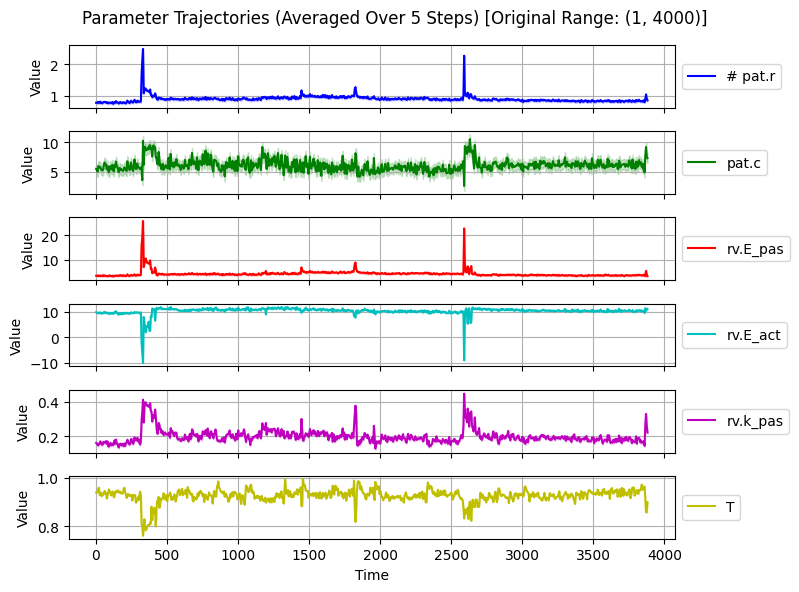

In [30]:
import numpy as np
import matplotlib.pyplot as plt

class ResolutionController:
    def __init__(self, window_size):
        self.window_size = window_size

    def downsample(self, data):
        """Downsamples the data by averaging over non-overlapping windows."""
        if data.shape[0] < self.window_size:
            raise ValueError(f"Data has fewer than {self.window_size} time steps!")

        num_windows = data.shape[0] // self.window_size  # Compute number of full windows
        return data[:num_windows * self.window_size].reshape(num_windows, self.window_size, -1).mean(axis=1)

# Initialize resolution controller
window_size = 5
res_controller = ResolutionController(window_size)

# Define time range before downsampling
time_range = (1, 4000)  # Specify the indices from the original data

# Ensure posterior_variances has shape (3888, p)
posterior_variances_corrected = np.array(Sigma_post).diagonal().reshape(1, -1)  # (1, p)
posterior_variances_corrected = np.tile(posterior_variances_corrected, (posterior_means.shape[0], 1))  # (3888, p)


# Slice the original data before downsampling
posterior_means_trimmed = posterior_means[time_range[0]:time_range[1]]
posterior_variances_trimmed = posterior_variances_corrected[time_range[0]:time_range[1]]

# Downsample the sliced data
posterior_means_smooth = res_controller.downsample(posterior_means_trimmed)  # (new_length, p)
posterior_variances_smooth = res_controller.downsample(np.sqrt(posterior_variances_trimmed))  # (new_length, p)


# Generate new time indices based on downsampling
T_smooth = np.arange(posterior_means_smooth.shape[0]) * window_size + time_range[0]

# Colors for different parameters
colors = ['b', 'g', 'r', 'c', 'm', 'y']
param_names = bc.param_names
print(param_names)
# Plot each parameter on a separate subplot
fig, axes = plt.subplots(6, 1, figsize=(8, 6), sharex=True)

for i in range(len(param_names)):
    mean = posterior_means_smooth[:, i]  # Smoothed mean
    std_dev = posterior_variances_smooth[:, i]  # Smoothed standard deviation

    axes[i].plot(T_smooth, mean, color=colors[i], label=param_names[i])
    axes[i].fill_between(T_smooth, mean - 2 * std_dev, mean + 2 * std_dev, color=colors[i], alpha=0.2)

    axes[i].set_ylabel('Value')
    axes[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    axes[i].grid()

axes[-1].set_xlabel('Time')
fig.suptitle(f'Parameter Trajectories (Averaged Over {window_size} Steps) [Original Range: {time_range}]')

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make space for legends on the right
plt.show()

### With observation and model error

In [ ]:
## Define priors
# mean
c_svn_mu = 20.5
r_pat_mu = 0.31
c_pat_mu = 3.8
rv_mu = 1.15

# variances
c_svn_sd = 3.42**2
r_pat_sd = 0.05**2
c_pat_sd = 0.63**2
rv_sd = 0.48**2

# Model error
epsilon_model = np.diag(selected_rows['RSE']**2)

# Observation error 
obs_error_scale = 0.05
obs_error = np.std(observation_data)*obs_error_scale
epsilon_obs = np.diag(obs_error)

# total error
full_error = epsilon_obs + epsilon_model

# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)
intercept = intercept.reshape(len(intercept), 1)


posterior_means = []

for row in range(len(observation_data)):
 
 # dynamically define prior on T
 t_mu = filtered_output['iT'][row]
 t_sd = 0.00001**2
 mu_0 = np.array([c_svn_mu, r_pat_mu, c_pat_mu, rv_mu, t_mu])[:, np.newaxis]
 Sd = [c_svn_sd, r_pat_sd, c_pat_sd, rv_sd, t_sd]
 Sigma_0 = np.diag(Sd)


 # Select observation and reshape to be (d, 1)
 Y_obs = np.array(filtered_output.T[row])
 Y_obs = Y_obs.reshape(len(Y_obs), 1)
 
  
 #  Scale observation by intercepts of models
 Y_scaled = Y_obs - intercept
 

 # Compute the posterior covariance
 Sigma_post_inv = (beta_matrix.T @ np.linalg.inv(full_error) @ beta_matrix) + np.linalg.inv(Sigma_0)
 Sigma_post = np.linalg.inv(Sigma_post_inv)
 
 # Compute the posterior mean
 Mu_post = Sigma_post @ (beta_matrix.T @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)


 # Cmpute the posterior mean
 Mu_post = Sigma_post @ (beta_matrix.T @ np.linalg.inv(full_error) @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)

 
 posterior_means.append(Mu_post.squeeze()) 


posterior_means = np.array(posterior_means)